In [ ]:
import os
import copy
import time
import torch
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.amp import autocast
from torch.amp import GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from google.colab import drive
import random
import numpy as np
from PIL import Image
from torchvision.datasets import ImageFolder

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/datasets/Teeth_Dataset'

Mounted at /content/drive


In [ ]:

# ------------------------------
# Set random seed for reproducibility
# ------------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ------------------------------
# Define data transformations
# ------------------------------
data_transforms = {
    'Training': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'Validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}


image_datasets = {
    x: ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['Training', 'Validation', 'Testing']
}

# ------------------------------
# Create data loaders
# ------------------------------
dataloaders = {
    'Training': DataLoader(image_datasets['Training'], batch_size=16, shuffle=True, num_workers=2, drop_last=True),
    'Validation': DataLoader(image_datasets['Validation'], batch_size=16, shuffle=False, num_workers=2, drop_last=False),
    'Testing': DataLoader(image_datasets['Testing'], batch_size=16, shuffle=False, num_workers=2, drop_last=False),
}

# ------------------------------
# Dataset info
# ------------------------------
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Validation', 'Testing']}
class_names = image_datasets['Training'].classes
num_classes = len(class_names)

print(f"Dataset sizes - Training: {dataset_sizes['Training']}, Validation: {dataset_sizes['Validation']}, Testing: {dataset_sizes['Testing']}")
print(f"Class names: {class_names}")


Dataset sizes - Training: 3087, Validation: 1028, Testing: 1007
Class names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


In [ ]:
import timm
import torch.nn as nn

# Choose the variant (e.g., inception_resnet_v2)
model = timm.create_model('inception_resnet_v2', pretrained=True, num_classes=num_classes)

print(model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

InceptionResnetV2(
  (conv2d_1a): ConvNormAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (conv2d_2a): ConvNormAct(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (conv2d_2b): ConvNormAct(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): ConvNormAct(
    (conv): Conv2d(64, 80, kernel_size=(1, 

In [ ]:
import copy

def train_model(model, model_name, dataloaders, dataset_sizes, device, num_epochs=50):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3,
                                              steps_per_epoch=len(dataloaders['Training']),
                                              epochs=num_epochs)
    scaler = GradScaler(device='cuda')

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_without_improvement = 0

    history = {
        'training_loss': [],
        'training_acc': [],
        'validation_loss': [],
        'validation_acc': []
    }

    for epoch in range(num_epochs):
        print(f"\n[{model_name}] Epoch {epoch+1}/{num_epochs}")
        for phase in ['Training', 'Validation']:
            is_train = phase == 'Training'
            model.train() if is_train else model.eval()
            running_loss, running_corrects = 0.0, 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(is_train):
                    with autocast(device_type='cuda'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                    if is_train:
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()
                        scheduler.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            history[f'{phase.lower()}_loss'].append(epoch_loss)
            history[f'{phase.lower()}_acc'].append(epoch_acc.item())

            current_lr = optimizer.param_groups[0]['lr']
            print(f"{phase}: Loss {epoch_loss:.4f} Acc {epoch_acc:.4f} | LR: {current_lr:.6f}")

            if phase == 'Validation':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_without_improvement = 0
                else:
                    epochs_without_improvement += 1


    model.load_state_dict(best_model_wts)
    return model, history, best_acc


In [ ]:
def plot_metrics(history, model_name):
    epochs = range(1, len(history['training_loss']) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['training_acc'], label='Train Acc')
    plt.plot(epochs, history['validation_acc'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['training_loss'], label='Train Loss')
    plt.plot(epochs, history['validation_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
model_name = "InceptionResNetV2"
trained_model, history, best_val_acc = train_model(
    model, model_name, dataloaders, dataset_sizes, device, num_epochs=50
)


[InceptionResNetV2] Epoch 1/50
Training: Loss 1.2569 Acc 0.6476 | LR: 0.000050
Validation: Loss nan Acc 0.9008 | LR: 0.000050

[InceptionResNetV2] Epoch 2/50
Training: Loss 0.5720 Acc 0.9550 | LR: 0.000082
Validation: Loss 0.6724 Acc 0.9698 | LR: 0.000082

[InceptionResNetV2] Epoch 3/50
Training: Loss 0.5206 Acc 0.9728 | LR: 0.000132
Validation: Loss 0.6173 Acc 0.9669 | LR: 0.000132

[InceptionResNetV2] Epoch 4/50
Training: Loss 0.5389 Acc 0.9657 | LR: 0.000199
Validation: Loss 0.7945 Acc 0.9514 | LR: 0.000199

[InceptionResNetV2] Epoch 5/50
Training: Loss 0.5698 Acc 0.9504 | LR: 0.000280
Validation: Loss 0.8013 Acc 0.9144 | LR: 0.000280

[InceptionResNetV2] Epoch 6/50
Training: Loss 0.5732 Acc 0.9566 | LR: 0.000372
Validation: Loss 0.5918 Acc 0.9553 | LR: 0.000372

[InceptionResNetV2] Epoch 7/50
Training: Loss 0.5499 Acc 0.9595 | LR: 0.000470
Validation: Loss 0.6746 Acc 0.9348 | LR: 0.000470

[InceptionResNetV2] Epoch 8/50
Training: Loss 0.5778 Acc 0.9508 | LR: 0.000570
Validation: L

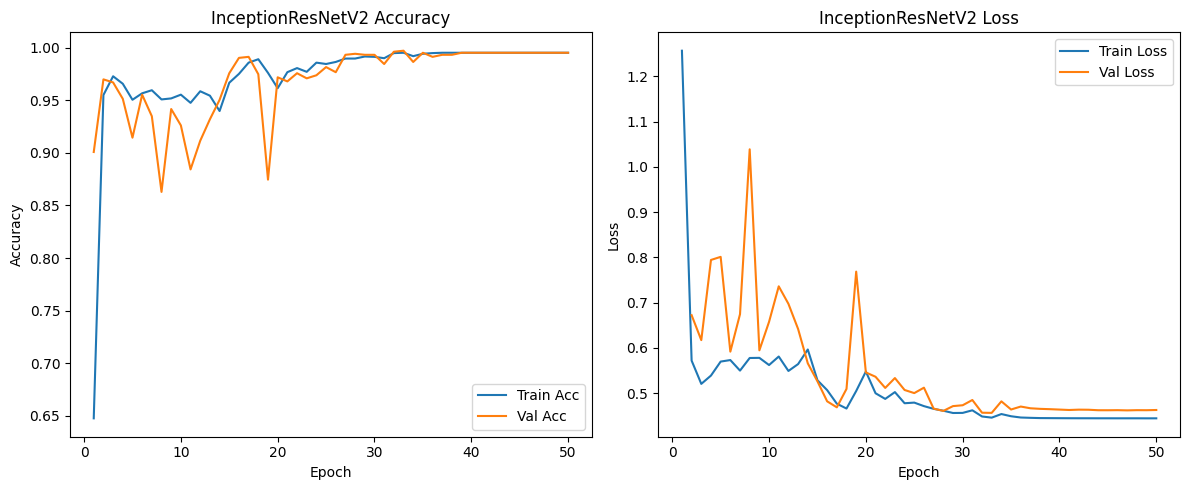

In [ ]:
plot_metrics(history, model_name)

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
# Track misclassified examples
misclassified = []
misclassified_images = []

def evaluate_model(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if preds[i] != labels[i]:
                    misclassified.append({
                        'true_label': labels[i].item(),
                        'pred_label': preds[i].item(),
                        'image_tensor': inputs[i].detach().cpu()
                    })

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:\n", cm)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()



Confusion Matrix:
 [[157   0   0   0   0   0   0]
 [  0 146   0   0   0   0   0]
 [  0   0 117   0   0   0   0]
 [  0   0   0 175   2   0   0]
 [  0   0   0   1 104   0   0]
 [  1   0   0   0   0 176   0]
 [  0   0   0   0   0   0 128]]

Classification Report:
              precision    recall  f1-score   support

         CaS     0.9937    1.0000    0.9968       157
         CoS     1.0000    1.0000    1.0000       146
         Gum     1.0000    1.0000    1.0000       117
          MC     0.9943    0.9887    0.9915       177
          OC     0.9811    0.9905    0.9858       105
         OLP     1.0000    0.9944    0.9972       177
          OT     1.0000    1.0000    1.0000       128

    accuracy                         0.9960      1007
   macro avg     0.9956    0.9962    0.9959      1007
weighted avg     0.9960    0.9960    0.9960      1007



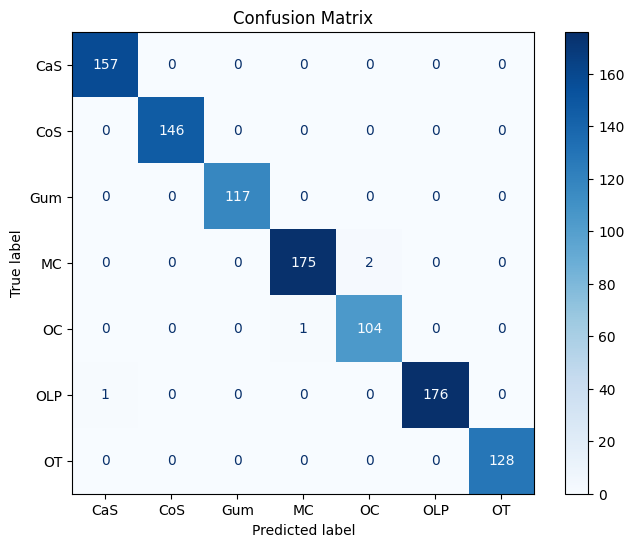

In [ ]:
# Assume test_loader and class_names are defined
evaluate_model(model, dataloaders['Testing'], class_names, device)

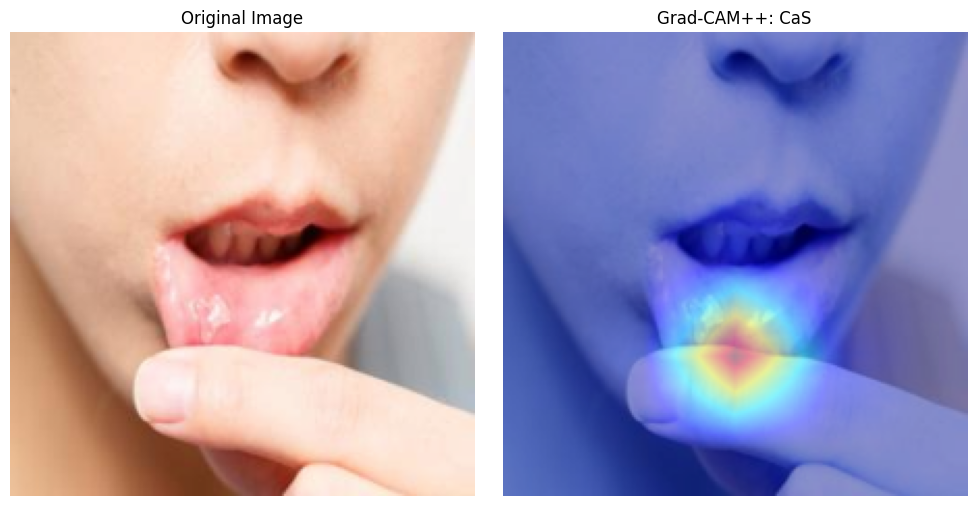

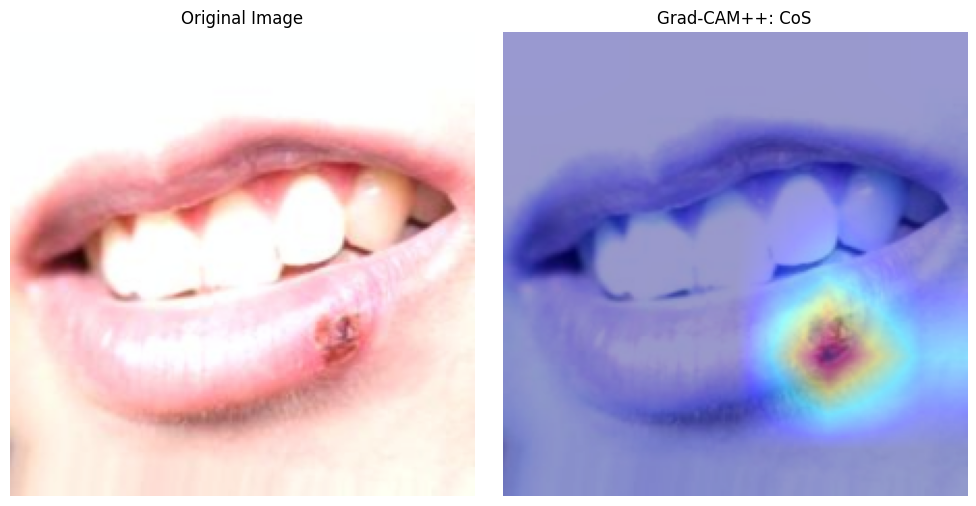

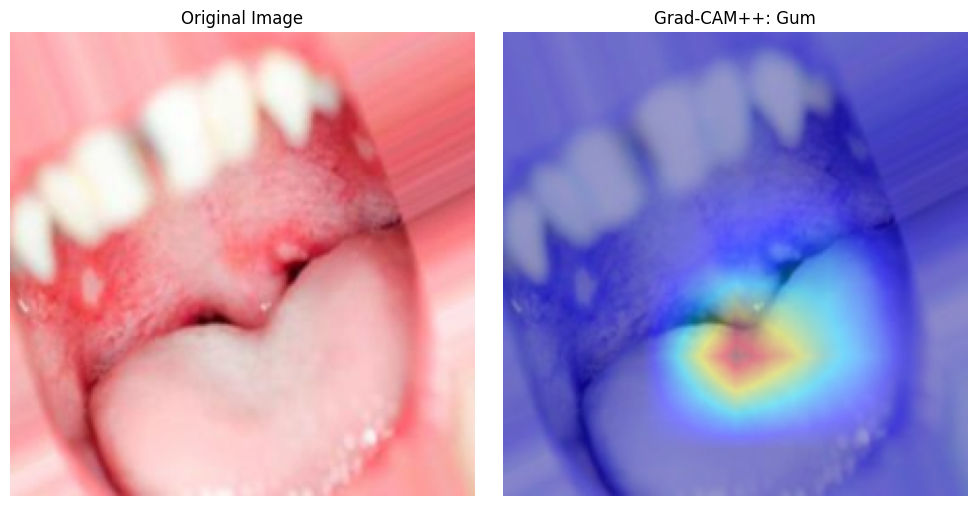

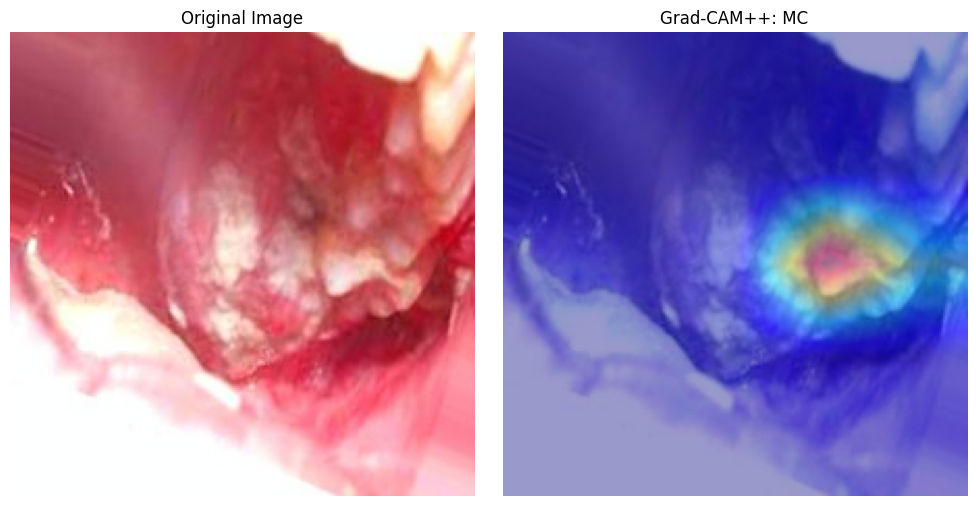

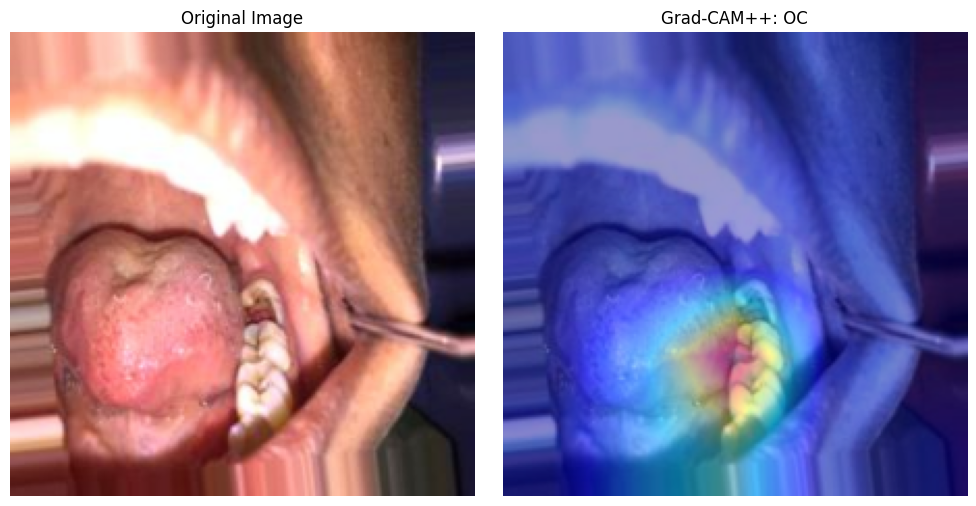

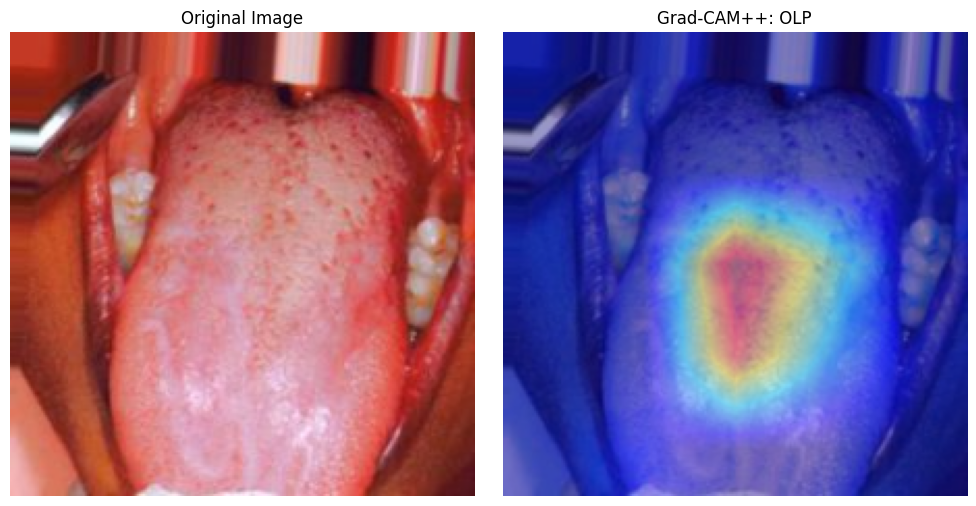

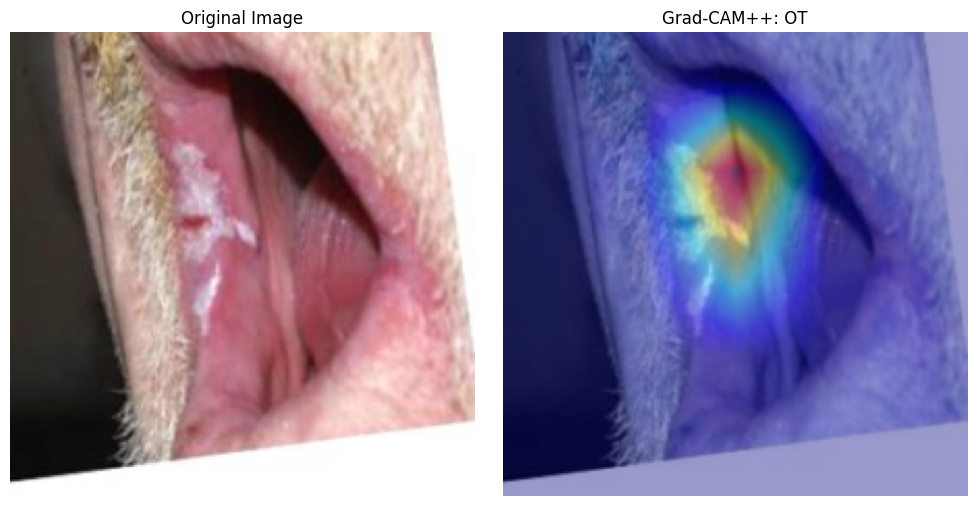

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# --- Hook Variables ---
feature_maps = None
gradients = None

# --- Hook Functions ---
def save_feature_maps(module, input, output):
    global feature_maps
    feature_maps = output

def save_gradients(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

# Register hooks to the last conv layer
target_layer = model.conv2d_7b  # For inception_resnet_v2
target_layer.register_forward_hook(save_feature_maps)
target_layer.register_full_backward_hook(save_gradients)

# --- Grad-CAM++ Implementation ---
def generate_gradcam_plus(model, image_tensor, class_idx=None):
    image_tensor = image_tensor.unsqueeze(0).to(device)
    output = model(image_tensor)

    if class_idx is None:
        class_idx = torch.argmax(output).item()

    model.zero_grad()
    score = output[0, class_idx]
    score.backward(retain_graph=True)

    grads = gradients[0]  # [C, H, W]
    fmap = feature_maps[0]  # [C, H, W]

    grads_power_2 = grads ** 2
    grads_power_3 = grads ** 3

    global_sum = torch.sum(fmap * grads_power_2, dim=[1, 2], keepdim=True)
    eps = 1e-8
    alpha = grads_power_2 / (2 * grads_power_2 + global_sum * grads_power_3 + eps)
    weights = torch.sum(alpha * torch.relu(grads), dim=[1, 2])  # [C]

    cam = torch.sum(weights[:, None, None] * fmap, dim=0)
    cam = torch.relu(cam).cpu().detach().numpy()
    cam = cv2.resize(cam, (image_tensor.shape[2], image_tensor.shape[3]))
    cam = (cam - np.min(cam)) / (np.max(cam) + 1e-8)

    return cam, class_idx

# --- Grad-CAM++ Visualization ---
def show_gradcam(image_tensor, heatmap, class_idx, class_names):
    img = image_tensor.cpu().numpy().transpose(1, 2, 0)
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img = np.clip(img, 0, 1)
    img_uint8 = np.uint8(img * 255)

    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img_uint8, 0.6, heatmap_colored, 0.4, 0)
    superimposed_rgb = cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(superimposed_rgb)
    axs[1].set_title(f'Grad-CAM++: {class_names[class_idx]}')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

# --- Pick random image from each class ---
class_to_images = {i: [] for i in range(len(class_names))}

for inputs, labels in dataloaders['Testing']:
    for img, label in zip(inputs, labels):
        if len(class_to_images[label.item()]) < 1:
            class_to_images[label.item()].append(img)
    if all(len(imgs) > 0 for imgs in class_to_images.values()):
        break  # One per class found

# Show Grad-CAM++ for one image per class
for class_id, imgs in class_to_images.items():
    img_tensor = imgs[0].to(device)
    heatmap, pred_idx = generate_gradcam_plus(model, img_tensor)
    show_gradcam(img_tensor, heatmap, pred_idx, class_names)


In [ ]:
# Replace with your actual model and desired save path
save_path = '/content/drive/MyDrive/datasets/model_teeth_V2.pth'
torch.save(model.state_dict(), save_path)

In [ ]:
import torch
import timm
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# --- Device ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Load InceptionResNetV2 ---
num_classes = 7  # update this as needed
class_names = ["CaS", "CoS", "Gum", "MC", "OC", "OLP", "OT"]  # example class names

model = timm.create_model('inception_resnet_v2', pretrained=True, num_classes=num_classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/datasets/model_teeth_V2.pth'))
model.to(device)
model.eval()

# --- Hook variables for Grad-CAM++ ---
feature_maps = None
gradients = None

def save_feature_maps(module, input, output):
    global feature_maps
    feature_maps = output

def save_gradients(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

# Register hooks on final conv layer of InceptionResNetV2
target_layer = model.conv2d_7b
target_layer.register_forward_hook(save_feature_maps)
target_layer.register_full_backward_hook(save_gradients)

# --- Data Transform ---
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # InceptionResNetV2 default input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Grad-CAM++ ---
def generate_gradcam_plus(image_tensor, class_idx=None):
    image_tensor = image_tensor.unsqueeze(0).to(device)
    output = model(image_tensor)

    if class_idx is None:
        class_idx = torch.argmax(output).item()

    model.zero_grad()
    class_score = output[0, class_idx]
    class_score.backward(retain_graph=True)

    grads = gradients[0]  # [C, H, W]
    fmap = feature_maps[0]  # [C, H, W]

    grads_power_2 = grads ** 2
    grads_power_3 = grads ** 3

    global_sum = torch.sum(fmap * grads_power_2, dim=[1, 2], keepdim=True)
    eps = 1e-8
    alpha = grads_power_2 / (2 * grads_power_2 + global_sum * grads_power_3 + eps)
    weights = torch.sum(alpha * torch.relu(grads), dim=[1, 2])  # [C]

    cam = torch.sum(weights[:, None, None] * fmap, dim=0)
    cam = torch.relu(cam).cpu().detach().numpy()
    cam = cv2.resize(cam, (image_tensor.shape[3], image_tensor.shape[2]))
    cam = (cam - np.min(cam)) / (np.max(cam) + 1e-8)
    return cam, output.softmax(dim=1)[0][class_idx].item(), class_idx

# --- Visualization ---
def show_gradcam(original_image, heatmap, class_idx, confidence):
    img = original_image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img = np.clip(img, 0, 1)
    img_uint8 = np.uint8(img * 255)

    heatmap_resized = cv2.resize(heatmap, (img_uint8.shape[1], img_uint8.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img_uint8, 0.6, heatmap_colored, 0.4, 0)
    superimposed_rgb = cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img)
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    axs[1].imshow(superimposed_rgb)
    axs[1].set_title(f"Grad-CAM++: {class_names[class_idx]} ({confidence*100:.2f}%)")
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()

# --- Prediction Pipeline ---
def predict_and_explain(image_path):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image)

    heatmap, confidence, class_idx = generate_gradcam_plus(image_tensor)
    show_gradcam(image_tensor.permute(1, 2, 0).numpy(), heatmap, class_idx, confidence)

    predicted_class = class_names[class_idx]
    print(f"\n🧠 Predicted: {predicted_class} ({confidence*100:.2f}%)\n")
    print("📋 Suggested Explanation:\n")
    suggest_with_llm(predicted_class, confidence)

# --- Hugging Face LLM API Call ---
import requests

API_URL = "https://router.huggingface.co/v1/chat/completions"
headers = {
    "Authorization": f"",
}

def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

def suggest_with_llm(disease_name, confidence):
    disease_info = {
        "CaS": "Canker Sores (CaS) – Painful ulcers inside the mouth.",
        "CoS": "Cold Sores (CoS) – Blisters caused by the herpes simplex virus.",
        "Gum": "Gingivostomatitis (Gum) – Inflammation of the gums and oral mucosa.",
        "MC": "Mouth Cancer (MC) – Malignant tumors in the oral cavity.",
        "OC": "Oral Cancer (OC) – Cancer affecting lips, tongue, or throat.",
        "OLP": "Oral Lichen Planus (OLP) – Chronic inflammatory condition.",
        "OT": "Oral Thrush (OT) – Fungal infection caused by Candida albicans.",
    }

    disease_description = disease_info.get(disease_name, disease_name)

    prompt = f"""
You are a helpful dental assistant.

An image was classified as "{disease_description}" with confidence {confidence*100:.2f}%.

Please provide:
1. What this disease is.
2. Possible reasons why it occurs (suggestions, not diagnoses).
3. Suggested actions to manage or address it (suggestions, not medical advice).

Remember, these are suggestions only.
"""
    payload = {
        "model": "deepseek-ai/DeepSeek-R1-0528:fireworks-ai",
        "messages": [
            {"role": "user", "content": prompt}
        ]
    }
    response = query(payload)
    if response:
        explanation = response["choices"][0]["message"]["content"]
        print("\n🧠 LLM Explanation & Suggestions:\n")
        print(explanation)
    else:
        print("Failed to get explanation from LLM.")


FileUpload(value={}, accept='image/*', description='Upload')

✅ Image uploaded successfully.


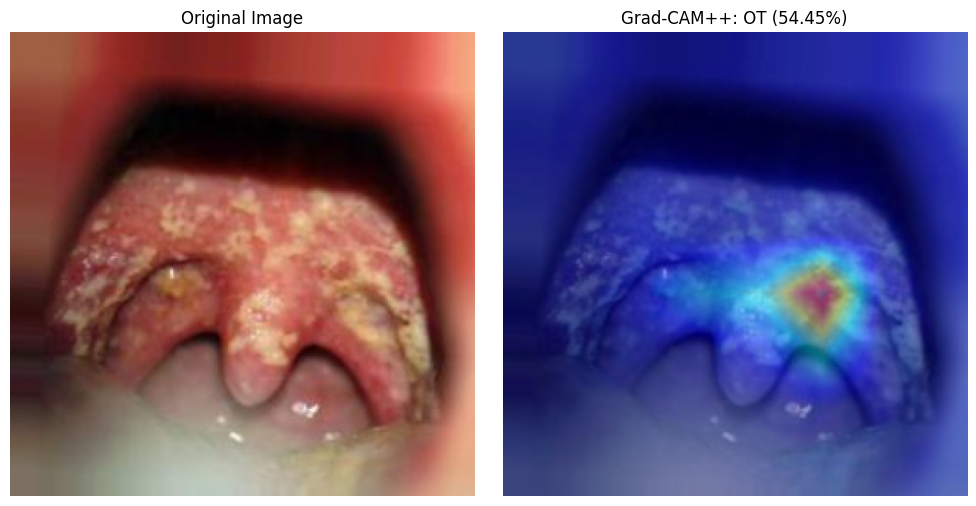


🧠 Predicted: OT (54.45%)

📋 Suggested Explanation:

Error 402: {"error":"You have exceeded your monthly included credits for Inference Providers. Subscribe to PRO to get 20x more monthly included credits."}
Failed to get explanation from LLM.


In [ ]:
# --- File Upload UI (Colab or Jupyter) ---
from IPython.display import display
import ipywidgets as widgets

uploader = widgets.FileUpload(accept='image/*', multiple=False)

def on_upload_change(change):
    if len(uploader.value) > 0:
        uploaded_file = list(uploader.value.values())[0]
        content = uploaded_file['content']

        with open("uploaded_image.jpg", "wb") as f:
            f.write(content)
        print("✅ Image uploaded successfully.")

        predict_and_explain("uploaded_image.jpg")

uploader.observe(on_upload_change, names='value')
display(uploader)
